[INFO] Using device: cuda


Experiments Progress: 100%|██████████| 20/20 [2:06:03<00:00, 378.16s/it]  


[RESULT] lr=0.001, epoch=30, kappa=0.2, mean=0.7107

=== Grid Search Summary ===
   decoder_lr  epoch  kappa  covering_metric
0       0.001     30    0.2         0.710655


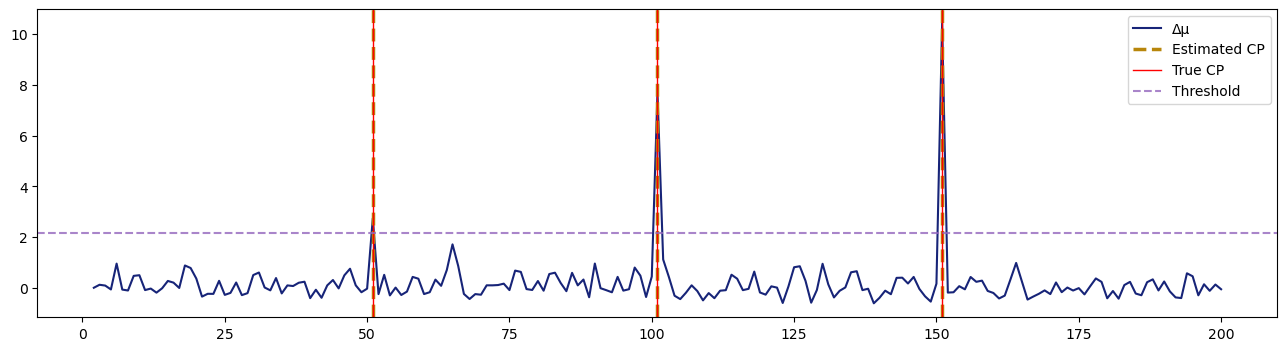

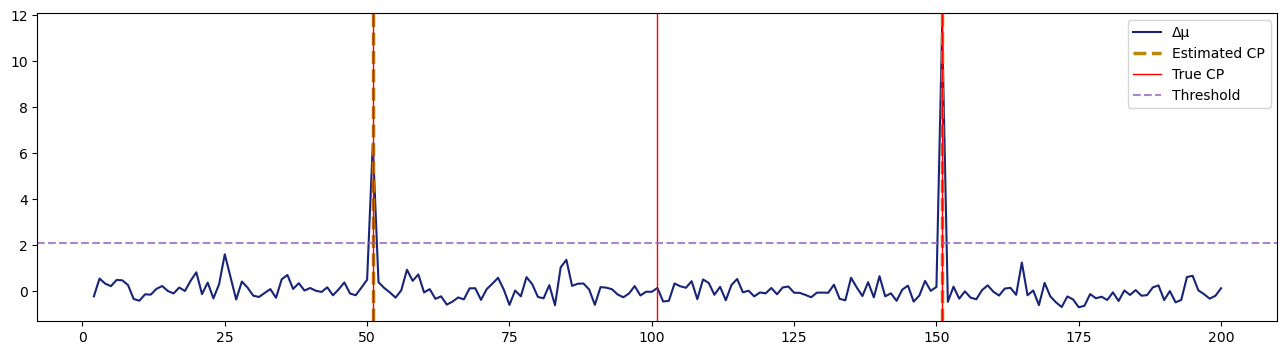

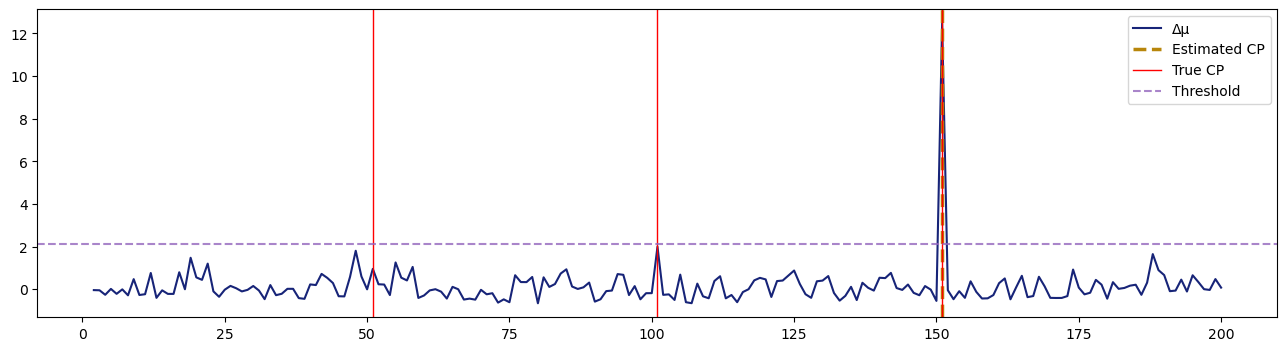

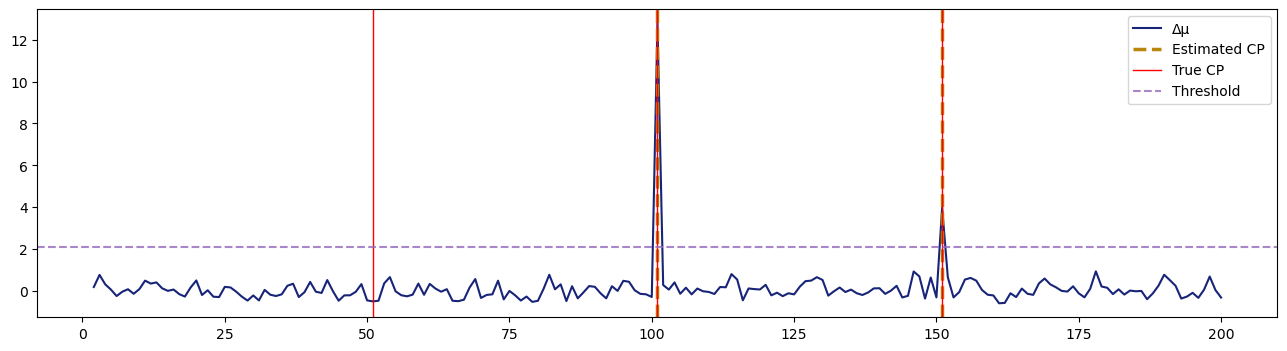

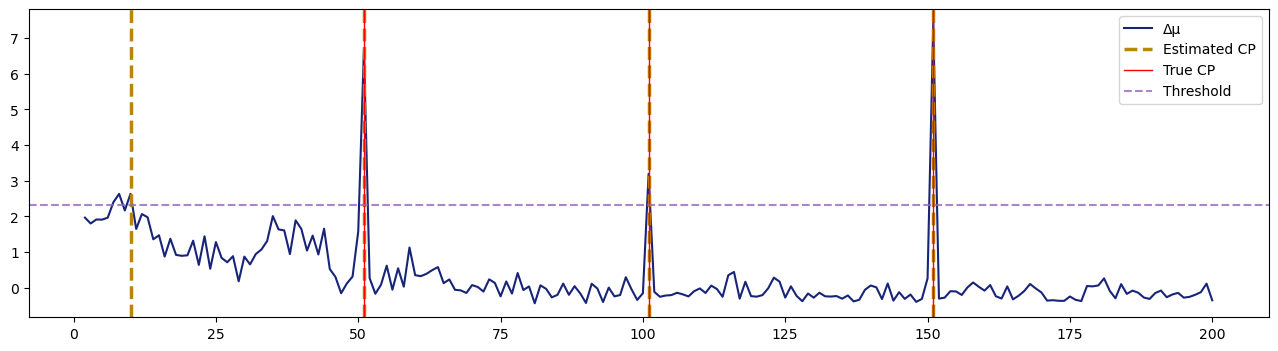

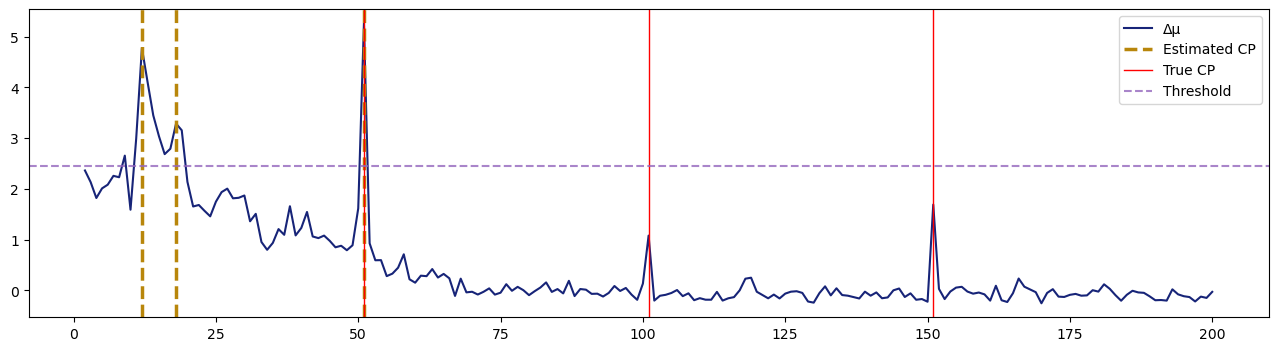

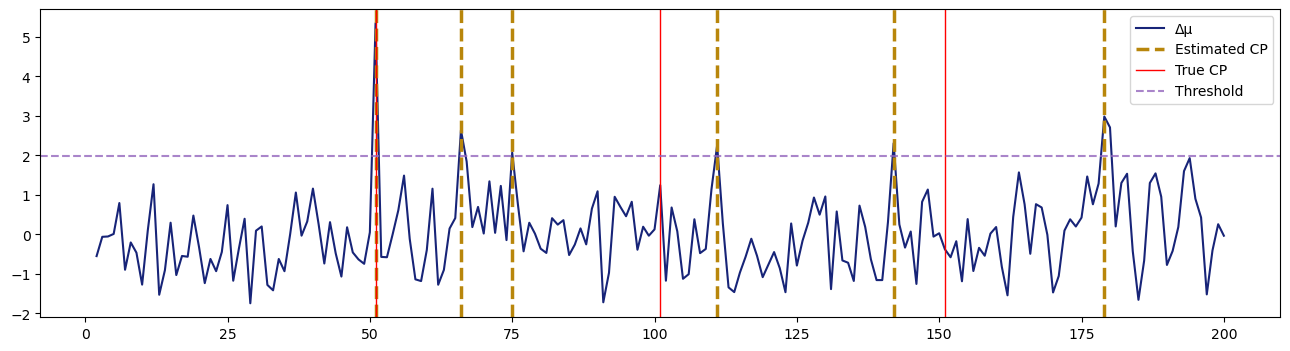

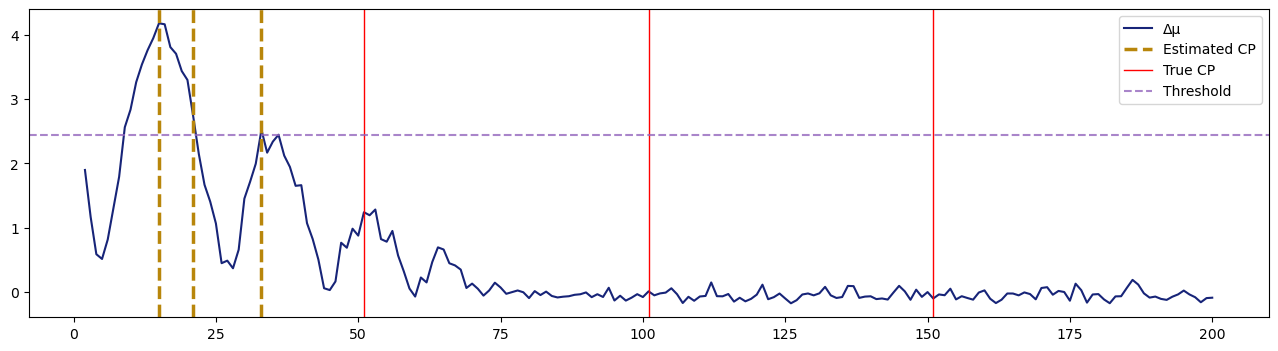

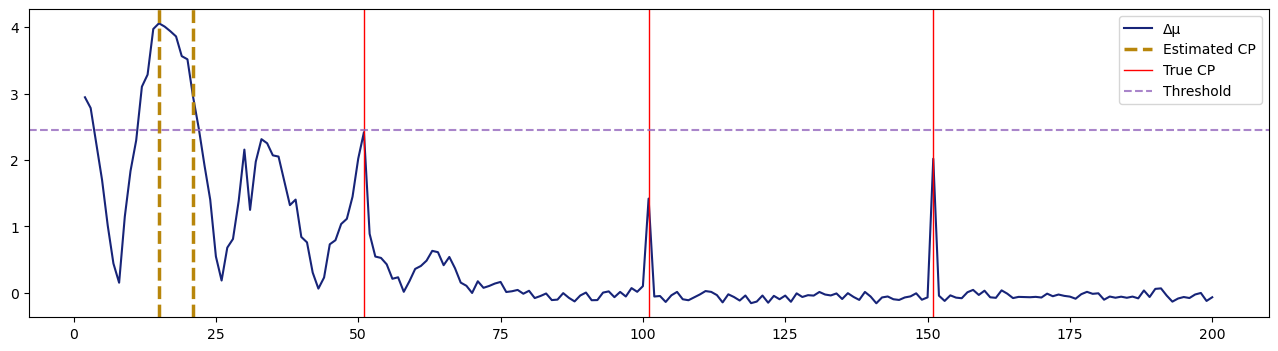

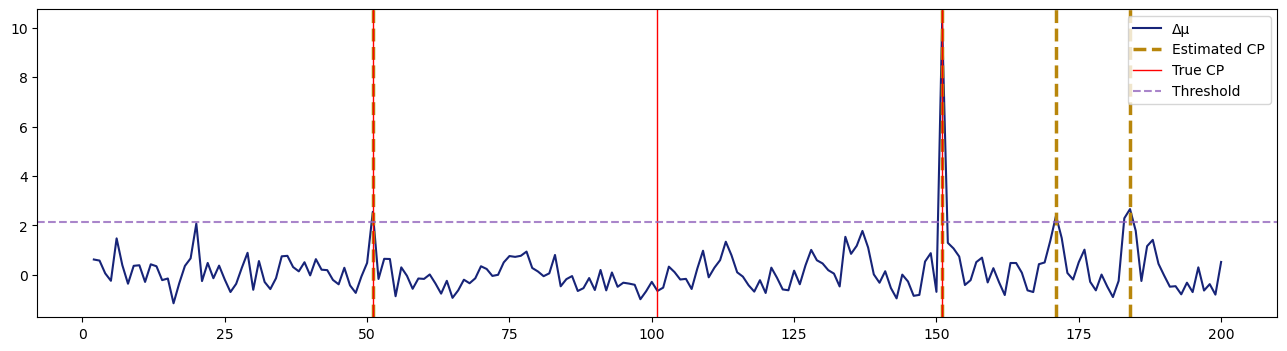

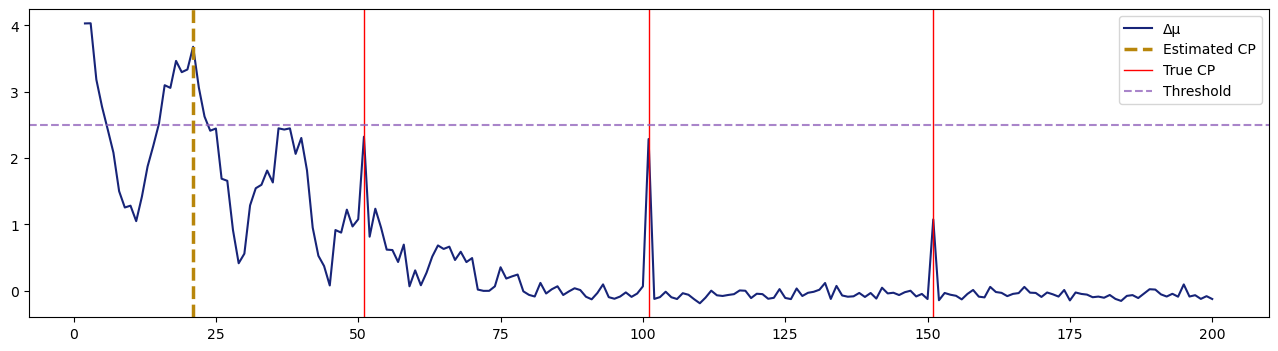

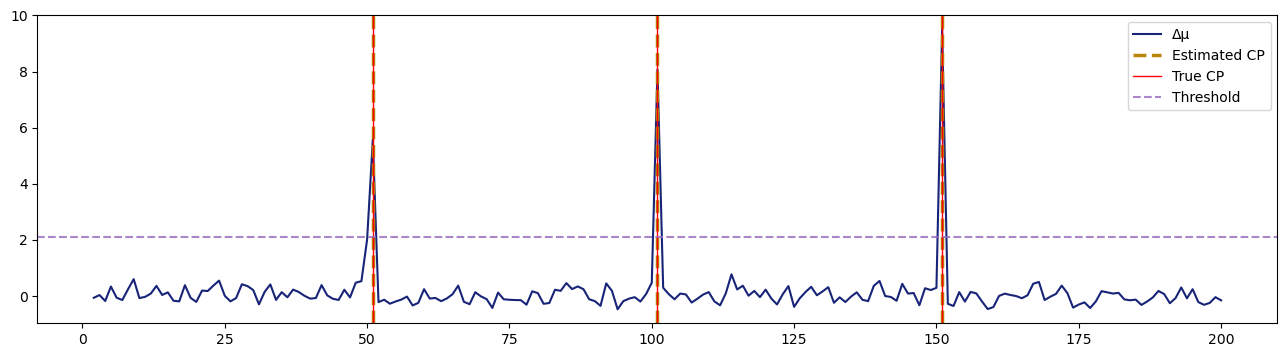

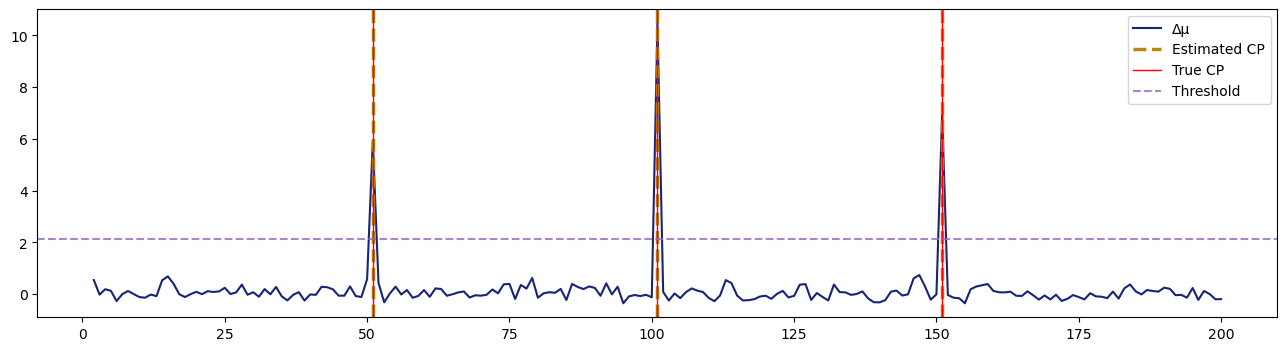

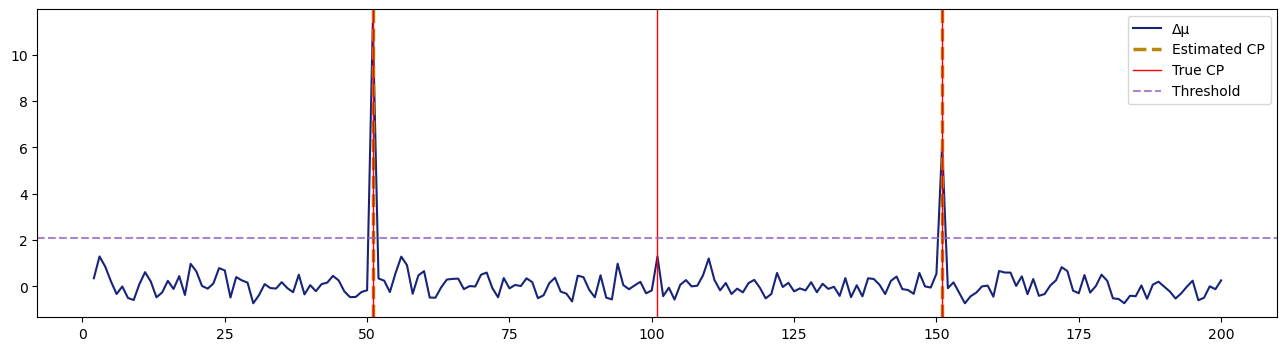

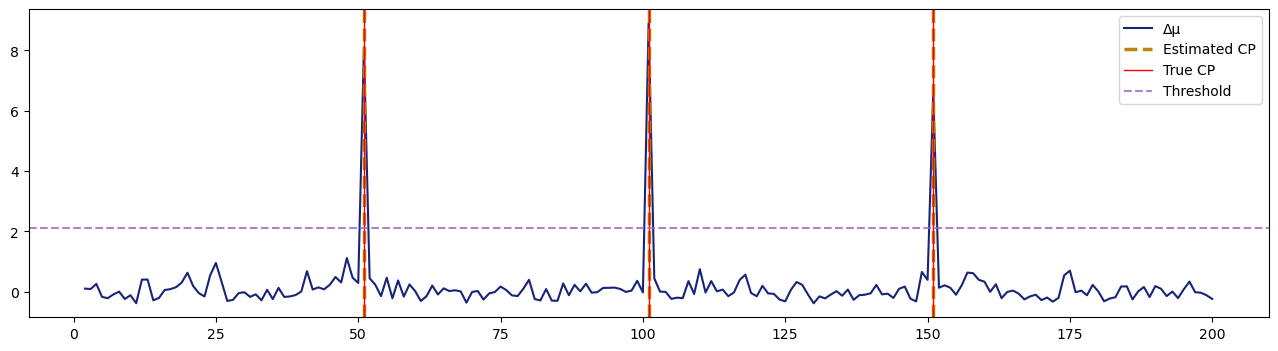

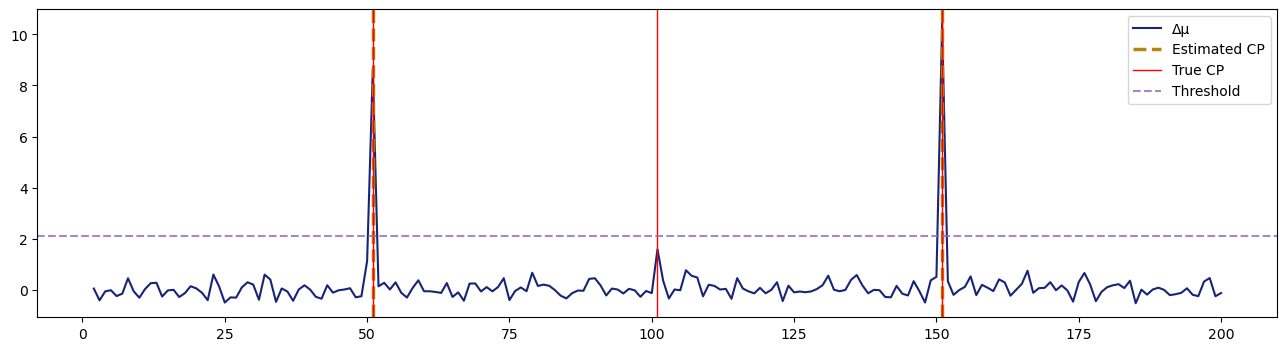

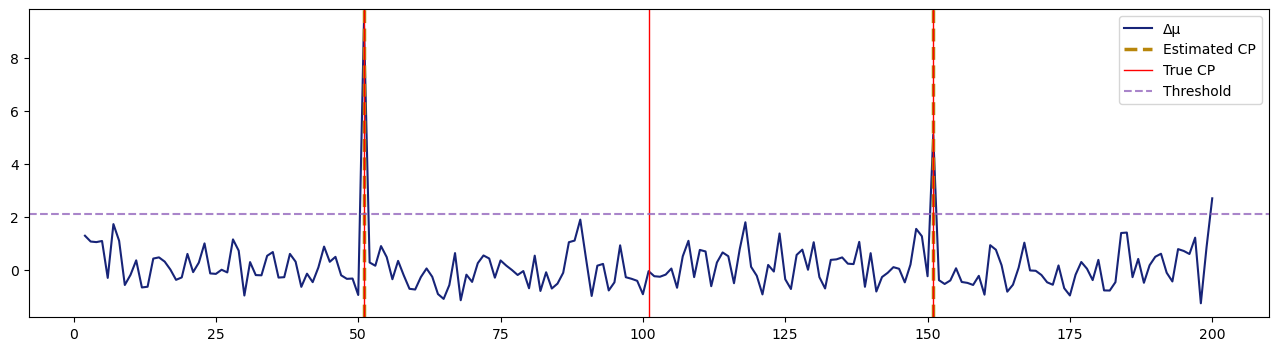

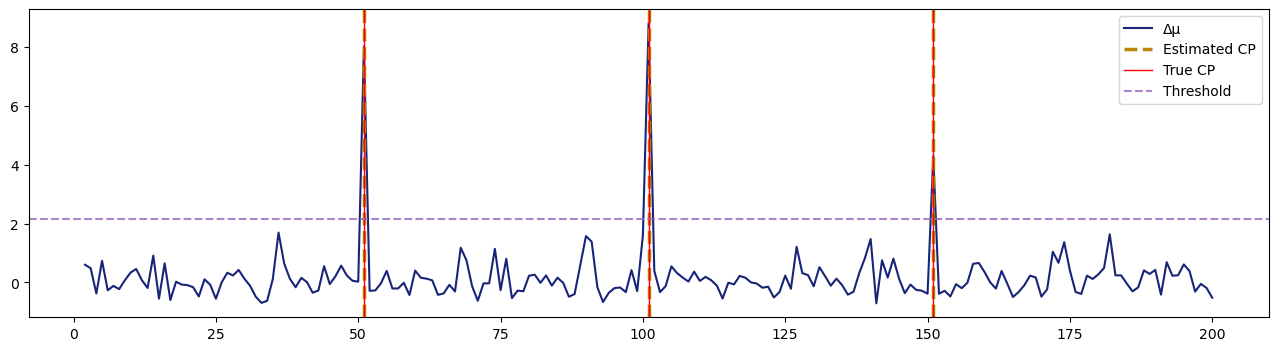

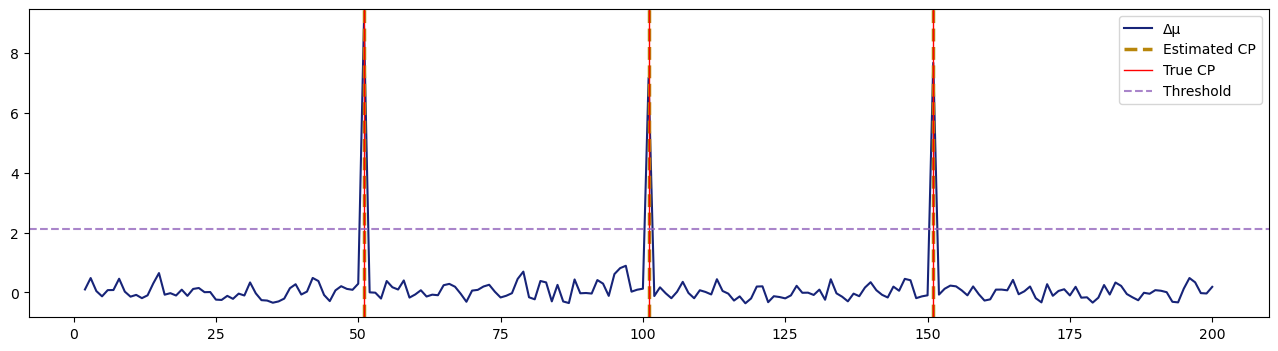

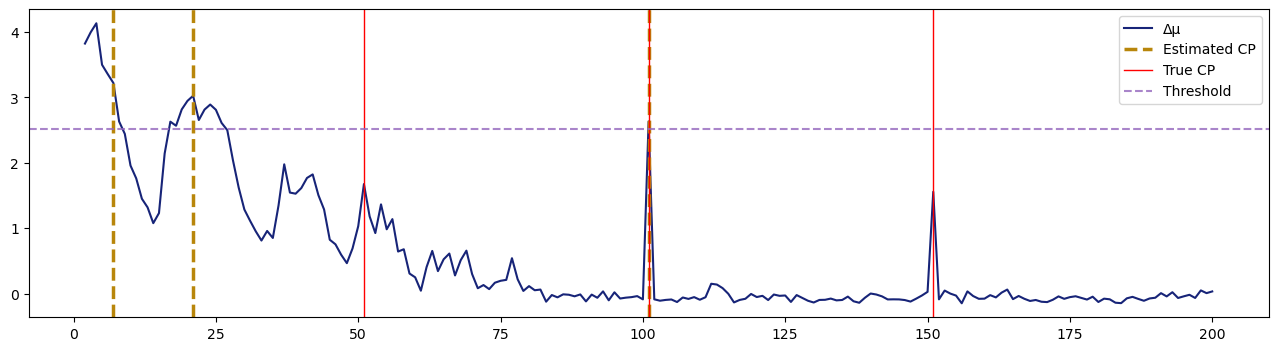

In [5]:
import torch
import numpy as np
import pandas as pd
from cpd_model import parse_args, learn_one_seq_penalty
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

args = parse_args()
args.num_time = 200
args.num_samples = 100
args.x_dim = 3
args.y_dim = 3
args.z_dim = 3
args.penalties = [0.1, 0.3, 0.5, 0.7, 1, 3, 5, 10]
args.outpulayer = [2000,2000]
args.decoder_iteration = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Using device:", device)

grid_decoder_lr = [1e-3]
grid_epoch = [30]
grid_kappa = [0.2]

n_repeats = 20
all_results = []

total_exps = len(grid_decoder_lr) * len(grid_epoch) * len(grid_kappa) * n_repeats

with tqdm(total=total_exps, desc="Experiments Progress") as pbar:
    for decoder_lr in grid_decoder_lr:
        for epoch in grid_epoch:
            for kappa in grid_kappa:
                args.decoder_lr = decoder_lr
                args.epoch = epoch
                args.kappa = kappa

                rep_results = []
                for rep in range(n_repeats):
                    dat_y = pd.read_csv(f"./reps_sim_dat/y_rep{rep}.csv").values
                    dat_x = pd.read_csv(f"./reps_sim_dat/x_rep{rep}.csv").values

                    T, N, dx, dy = args.num_time, args.num_samples, args.x_dim, args.y_dim
                    Y_array = dat_y.T.reshape(dy, N, T, order="F").transpose(2,1,0)
                    X_array = dat_x.T.reshape(dx, N, T, order="F").transpose(2,1,0)

                    x_input = torch.tensor(X_array, dtype=torch.float32).to(device)
                    y_input = torch.tensor(Y_array, dtype=torch.float32).to(device)

                    odd_idx, even_idx = range(1, T, 2), range(0, T, 2)
                    x_train, x_test = x_input[odd_idx].reshape(-1, dx), x_input[even_idx].reshape(-1, dx)
                    y_train, y_test = y_input[odd_idx].reshape(-1, dy), y_input[even_idx].reshape(-1, dy)

                    results_half = []
                    for penalty in args.penalties:
                        loss, pen = learn_one_seq_penalty(
                            args, x_train, y_train, x_test, y_test,
                            penalty=penalty, half=True
                        )
                        results_half.append([loss, pen])
                    results_half = np.array(results_half)
                    best_idx = np.argmin(results_half[:, 0])
                    best_penalty = args.penalties[best_idx]


                    res_full = learn_one_seq_penalty(
                        args,
                        x_input.reshape(-1, dx),
                        y_input.reshape(-1, dy),
                        x_input.reshape(-1, dx),
                        y_input.reshape(-1, dy),
                        penalty=best_penalty,
                        half=False
                    )

                    rep_results.append(res_full[3])  # covering_metric
                    all_results.append({
                        "rep": rep,
                        "epoch": epoch,
                        "decoder_lr": decoder_lr,
                        "kappa": kappa,
                        "best_penalty": best_penalty,
                        "covering_metric": res_full[3]
                    })


                    pbar.update(1)

                avg_score = np.mean(rep_results)
                tqdm.write(f"[RESULT] lr={decoder_lr}, epoch={epoch}, "
                           f"kappa={kappa}, mean={avg_score:.4f}")


df_results = pd.DataFrame(all_results)
df_summary = df_results.groupby(
    ["decoder_lr","epoch","kappa"]
)["covering_metric"].mean().reset_index()

print("\n=== Grid Search Summary ===")
print(df_summary)


# for epoch in grid_epoch:
#     pivot = df_summary[df_summary["epoch"]==epoch].pivot(
#         index="decoder_lr", columns="kappa", values="covering_metric"
#     )
#     plt.figure(figsize=(6,4))
#     sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
#     plt.title(f"Covering Metric (epoch={epoch})")
#     plt.ylabel("decoder_lr")
#     plt.xlabel("kappa")
#     plt.tight_layout()
#     plt.show()
#         0.001     30   0.20         0.870561

In [2]:
# df_results["res_full"].apply(lambda x: x[3]).mean()
df_results["best_penalty"]

0     0.5
1     5.0
2     0.1
3     0.1
4     0.1
5     0.1
6     1.0
7     1.0
8     0.5
9     0.1
10    0.5
11    0.1
12    0.1
13    0.1
14    0.1
15    1.0
16    0.5
17    0.1
18    0.1
19    0.5
Name: best_penalty, dtype: float64

In [ ]:
# accuracy: 0.84
# args = parse_args()
# args.epoch = 30           
# args.penalties = [0.01, 0.1, 0.5, 1, 5] 
# args.num_time = 200
# args.num_samples = 100
# args.x_dim = 3
# args.y_dim = 3
# args.z_dim = 1
# args.decoder_lr = 0.001